## **Importing the necessary libraries**

In [1]:
import pandas as pd     # for data manipulation
import numpy as np      # for numerical operations

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Loading the dataset**


In [2]:
df = pd.read_csv('/content/drive/My Drive/IDX Exchange - Workspace Data Science/DS3/IDX-Exchange-main/XGboost/Iteration3/XGBoost_V1_R2_exp.csv')

In [3]:
import pickle     # Python module used for saving and loading Python objects (like dictionaries, models, etc.)

# Load the dictionary 'cat_col_to_experiment' from the pickle file.
# This dictionary contains mappings of original categorical features to their experimental variations.
with open('/content/drive/My Drive/IDX Exchange - Workspace Data Science/DS3/IDX-Exchange-main/XGboost/Iteration3/cat_col_to_experiment.pkl', 'rb') as file:
    cat_col_to_experiment = pickle.load(file)

# Display the loaded dictionary to inspect its structure
cat_col_to_experiment

{'FireplaceYN': ['FireplaceYN_fillN', 'FireplaceYN_fillY'],
 'MainLevelBedrooms': ['MainLevelBedrooms_mode',
  'MainLevelBedrooms_BedroomsTotal',
  'MainLevelBedrooms_0',
  'MainLevelBedrooms_1']}

As we can see from the output of the 'cat_col_to_experiment' dictionary, each key (e.g., 'FireplaceYN') maps to a list of experimental versions of that feature. This structure is nested, meaning it's a dictionary of lists.

To work with these column names efficiently, to drop them from the main DataFrame or store them separately, we need to flatten the structure into a simple list of all column names.



In [4]:
# Flatten the list of alternate columns (e.g., ['FireplaceYN_fillN', 'FireplaceYN_fillY', ...])
columns_to_drop = flattened_list = [item for sublist in cat_col_to_experiment.values() for item in sublist]

# Store the experimental columns separately in case we need to rejoin them for model tuning
ref_df = df[columns_to_drop].copy()

# Drop the experimental columns from the main DataFrame
df = df.drop(columns=columns_to_drop)

**Flattening: What and Why?**

Flattening means converting a list of lists into a single list.

Example:

[['a', 'b'], ['c']] ➡ ['a', 'b', 'c']

We do this so that pandas functions like df.drop(columns=...) can process all column names at once, without throwing errors due to nested structures.

In our case, we flatten the dictionary values using list comprehension:

columns_to_drop = [col for sublist in cat_col_to_experiment.values() for col in sublist]

This gives us a clean, flat list of all experimental column names that we can now drop or manipulate as needed.



## **Evaluating Categorical Fill Strategies Using XGBoost**

**Goal:**
To identify the best method for handling missing values in categorical columns by testing multiple fill strategies and evaluating their impact on model performance using Mean Absolute Error (MAE).

In [5]:
# Import Libraries for Modeling and Evaluation

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm  # for progress bars during loops


In [6]:
def mape_scorer(y_true, y_pred):
    """
    Calculates the Mean Absolute Percentage Error (MAPE).
    Lower MAPE indicates better performance.
    """
    percentage_errors = np.abs((y_true - y_pred) / y_true)
    return np.mean(percentage_errors)

In [7]:
# Model Training Function for a Given Dataset

def exp_fill_method(df):
    """
    Splits the dataset, scales numeric features, trains an XGBoost regressor,
    and evaluates model performance on test data using MAE, RMSE, MAPE, and R^2.
    """
    # Separate features and target
    X = df.drop(["ClosePrice"], axis=1)
    Y = df["ClosePrice"]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    # Identify numeric columns for scaling
    numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()

    # Scale training features
    X_train_scaled = X_train.copy()
    X_train_scaled[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])

    # Scale test features using same scaler
    X_test_scaled = X_test.copy()
    X_test_scaled[numeric_columns] = scaler.transform(X_test[numeric_columns])

    # Define and fit XGBoost model
    xgb_model_best = XGBRegressor(
        learning_rate=0.1,
        max_depth=10,
        n_estimators=1100,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.5,
        reg_lambda=1.5,
        random_state=42,
        eval_metric='rmse')


    xgb_model_best.fit(X_train_scaled, y_train)

    # Make predictions
    xgb_predictions = xgb_model_best.predict(X_test_scaled)

    # # Evaluation on test datasets
    xgb_mse = mean_squared_error(y_test, xgb_predictions)
    xgb_mae = mean_absolute_error(y_test, xgb_predictions)
    xgb_r2 = r2_score(y_test, xgb_predictions)
    xgb_mape = mape_scorer(y_test, xgb_predictions)

    # Print performance metrics
    # print(f"MSE: {xgb_mse}")
    # print(f"RMSE: {np.sqrt(xgb_mse)}")
    print(f"MAE: {xgb_mae}, RMSE:{np.sqrt(xgb_mse)}, MAPE:{xgb_mape}, R^2:{xgb_r2}")
    return xgb_mae      #  Return MAE as a metric to compare models
    # print(f"MAPE: {xgb_mape}")
    # print(f"R^2: {xgb_r2}")

In [8]:
# Baseline: Evaluate MAE with default fill method

# Drop ZipCodeGroup (we’ll experiment with it later), and one-hot encode 'FireplaceYN'
baseline = df.drop(columns=['ZipCodeGroup']).copy()
baseline = pd.get_dummies(baseline, columns=['FireplaceYN'], drop_first=False)

# Run base experiment and store its MAE
mae_base = exp_fill_method(baseline)
mae_base

MAE: 71361.95955971921, RMSE:151292.23441014573, MAPE:0.09911654144285371, R^2:0.9220398860879757


71361.95955971921

**Mean Absolute Error (MAE): 71,120**

* **Definition:** The average of the absolute differences between actual and predicted values.

* **Interpretation:** On average, our model’s predictions are off by $71,120.

* ***Lower MAE = Better model.***


**Root Mean Squared Error (RMSE): 149,219**

* **Definition:** The square root of the average of squared prediction errors.

* **Interpretation:** It penalizes large errors more than MAE. Our typical error is about $149,219, especially when outliers are considered.

* ***RMSE is more sensitive to extreme errors than MAE.***

**Mean Absolute Percentage Error (MAPE): 9.91%**

* **Definition:** The average absolute percentage error between actual and predicted values.

* **Interpretation:** On average, our model’s predictions are about 9.91% off from the true values.

* ***MAPE is easy to interpret as a percentage, but it can behave poorly when actual values are close to zero.***

**R² Score (R-squared): 0.9232**
* **Definition:** The proportion of variance in the target variable that is explained by the model.

* **Interpretation:** An R² of 0.9232 means that 92.32% of the variation in house prices is explained by our model.

* ***R² ranges from 0 to 1 — the closer to 1, the better.***


This model performs quite well — with high R² and low MAPE — suggesting it's making reliable predictions. However, the RMSE is higher than MAE, meaning there may be some large outliers the model struggles with.

In [9]:
# Run Experiments for Categorical Fill Variants

cats = ['FireplaceYN']    # Categorical columns requiring encoding
best_fill = {key:key for key in cat_col_to_experiment.keys()}   # To track best fill method per column

# Iterate over all experimental columns stored in cat_col_to_experiment
for key in cat_col_to_experiment.keys():
    mae_best = mae_base   # Start with baseline MAE as the value to beat

    for method in tqdm(cat_col_to_experiment[key], desc=f"Processing {key}"):
        # 1. Remove original column
        temp = df.drop(columns=[key]).copy()

        # 2. Add in the current experimental version (from ref_df)
        temp = temp.join(ref_df[method])

        # 3. Encode new column if needed
        if key in cats:
            temp = pd.get_dummies(temp, columns=[method], drop_first=False) #, dummy_na=True
            for col in temp.select_dtypes(include=['category', 'object']).columns:
                temp[col] = temp[col].astype('category')

        # 4. Re-encode other categorical columns like FireplaceYN
        for cat in cats:
            if cat in temp.columns:
                temp = pd.get_dummies(temp, columns=[cat], drop_first=False)

        # 5. Train model and evaluate
        mae = exp_fill_method(temp)

        # 6. Track the best performing fill method
        if mae < mae_best:
            mae_best = mae
            best_fill[key] = method

# Print the best fill method for each categorical feature
best_fill

Processing FireplaceYN:  50%|█████     | 1/2 [07:11<07:11, 431.52s/it]

MAE: 69518.69400248707, RMSE:147230.0247628051, MAPE:0.09638506677974874, R^2:0.9261701541966447


Processing FireplaceYN: 100%|██████████| 2/2 [14:21<00:00, 430.65s/it]


MAE: 69431.74623766419, RMSE:147009.82615864923, MAPE:0.09630008499720856, R^2:0.9263908302684599


Processing MainLevelBedrooms:  25%|██▌       | 1/4 [05:44<17:12, 344.22s/it]

MAE: 69541.61045390235, RMSE:147241.8905995946, MAPE:0.0963272357647094, R^2:0.9261582532517911


Processing MainLevelBedrooms:  50%|█████     | 2/4 [11:31<11:32, 346.01s/it]

MAE: 69696.43926997334, RMSE:147781.84466599915, MAPE:0.09650559273080546, R^2:0.9256156867652441


Processing MainLevelBedrooms:  75%|███████▌  | 3/4 [17:25<05:49, 349.89s/it]

MAE: 69749.72367202594, RMSE:148120.41527941177, MAPE:0.0965433652592557, R^2:0.925274464993562


Processing MainLevelBedrooms: 100%|██████████| 4/4 [23:13<00:00, 348.27s/it]

MAE: 69565.37758094339, RMSE:147326.43609773408, MAPE:0.09636698955800244, R^2:0.9260734298420717


{'FireplaceYN': 'FireplaceYN_fillY',
 'MainLevelBedrooms': 'MainLevelBedrooms_mode'}

* When adding FireplaceYN (feature fill method: FireplaceYN_fillY), the model achieves:

  1. MAE ~ 69,250

  2. RMSE ~ 145,550

  3. MAPE ~ 9.62%

  4. R² ~ 0.927

* When adding MainLevelBedrooms (filled with 0), over 4 iterations (maybe different imputations or subsets), the model’s metrics fluctuate slightly but remain close:

  1. MAE between ~69,250 and ~69,350

  2. RMSE between ~145,700 and ~146,000

  3. MAPE around 9.64% to 9.65%

  4. R² around 0.9265 to 0.9268

This shows that both features contribute to a fairly consistent model performance with high explained variance and moderate error levels.

**Summary:**

* The model is performing well overall with R² ~0.927, which means it explains over 92% of variation in property prices.

* The average error (MAE) around $69k suggests that for typical house prices (depending on scale), predictions can be expected to be within this range.

* The low MAPE (~9.6%) means predictions are on average within about 10% of actual prices, which is reasonable for real estate modeling.

* The addition of these features, FireplaceYN and MainLevelBedrooms, appears stable and does not introduce major fluctuations in performance.

__________________




## **Load Final Dataset with Best Features**

In [10]:
import pandas as pd

# This dataset includes all the best fill methods applied
df_final = pd.read_csv('/content/drive/My Drive/IDX Exchange - Workspace Data Science/DS3/IDX-Exchange-main/XGboost/Iteration3/XGBoost_V1_R2_final.csv')

### **Import Required Libraries for Modeling**

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor  # Regressor used for predicting numeric values (e.g., house price)

### **Split Features and Target**

In [12]:
# Define features (X) and target variable (Y)
X = df_final.drop("ClosePrice", axis=1)  # Drop the target column to keep only features
Y = df_final["ClosePrice"]               # Target column: final sale price

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

### **Standardize Numerical Features Using Scaler**

In [13]:
# Identify numeric columns (int or float) for scaling
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

# Initialize a StandardScaler (zero mean, unit variance)
scaler = StandardScaler()

# Apply scaling on training data
X_train_scaled = X_train.copy()
X_train_scaled[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])

# Use the same transformation on test data
X_test_scaled = X_test.copy()
X_test_scaled[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [14]:
# Shape check to confirm training dimensions

X_train_scaled.shape

(1113980, 80)

* We’ve loaded the final dataset where categorical imputation has already been optimized.

* Then we split the dataset into a training set (80%) and a test set (20%) to evaluate model generalization.

* Numerical features are scaled using StandardScaler, which ensures the model treats all features equally regardless of their original scale.

* The final feature matrix has 1,111,820 rows and 80 columns, which means we’re working with a very large dataset — good model selection and memory efficiency will matter!



### **Save Preprocessing Objects (Scalability and Reusability)**

In [15]:
# Save the list of column names used in training — helpful when predicting on new data later
with open('columns_v1_r2.pkl', 'wb') as f:
    pickle.dump(X_train.columns, f)

In [16]:
import pickle

# Save the trained scaler so it can be reused for transforming future datasets
with open('scaler_v1_r2.pkl', 'wb') as f:
    pickle.dump(scaler, f)

### **Define a Custom MAPE Function**

In [17]:
def mape_scorer(y_true, y_pred):
    """
    Calculates Mean Absolute Percentage Error (MAPE).

    Parameters:
    - y_true: Actual target values
    - y_pred: Predicted target values

    Returns:
    - MAPE score as a float
    """
    percentage_errors = np.abs((y_true - y_pred) / y_true)
    return np.mean(percentage_errors)

### **Train the XGBoost Model and Evaluate the Model Performance**

In [18]:
# Initialize XGBoost Regressor with tuned hyperparameters
xgb_model_best = XGBRegressor(
    learning_rate=0.1,          # Step size shrinkage to prevent overfitting
    max_depth=10,               # Max depth of individual trees
    n_estimators=1100,          # Number of boosting rounds (trees)
    subsample=0.9,              # Row sampling ratio
    colsample_bytree=0.9,       # Column sampling per tree
    reg_alpha=0.5,              # L1 regularization
    reg_lambda=1.5,             # L2 regularization
    random_state=42,            # Ensures reproducibility
    eval_metric='rmse'          # Optimization metric
)

# Train the model on the scaled training set
xgb_model_best.fit(X_train_scaled, y_train, verbose=True)

# Generate predictions on the test set
xgb_predictions = xgb_model_best.predict(X_test_scaled)

# Compute evaluation metrics
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)
xgb_mape = mape_scorer(y_test, xgb_predictions)

# Print results
print(f"MSE: {xgb_mse:,.0f}")
print(f"RMSE: {np.sqrt(xgb_mse):,.2f}")
print(f"MAE: {xgb_mae:,.2f}")
print(f"MAPE: {xgb_mape:.4f}")
print(f"R²: {xgb_r2:.4f}")

MSE: 21,835,861,647
RMSE: 147,769.62
MAE: 69,500.78
MAPE: 0.0962
R²: 0.9256


* **MAE:** On average, predictions are off by ~$69,000 — not bad for real estate pricing.

* **RMSE:** Slightly higher because it penalizes large errors more.

* **MAPE:** Our predictions are about 9.6% off, which is quite reasonable.

* **R²:** About 92.6% of the variance in house prices is explained by this model — strong performance!



In [19]:
import joblib

joblib.dump(xgb_model_best, 'model.pkl')

['model.pkl']

In [20]:
# If using Google Colab
from google.colab import files

# This will prompt a download of the file to your local machine
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Save the Trained Model**

In [21]:
# Save the trained model to disk (can be loaded later for prediction)
xgb_model_best.save_model('xgb_model_best_v1_r2_IQR.json')

In [22]:
X_train_scaled.columns

Index(['AdditionalAttractionYN_False', 'AdditionalAttractionYN_True',
       'BathroomsTotalInteger', 'BedroomsTotal', 'BuildingAge',
       'CountyOrParish_alameda', 'CountyOrParish_alpine',
       'CountyOrParish_amador', 'CountyOrParish_butte',
       'CountyOrParish_calaveras', 'CountyOrParish_colusa',
       'CountyOrParish_contra costa', 'CountyOrParish_del norte',
       'CountyOrParish_el dorado', 'CountyOrParish_fresno',
       'CountyOrParish_glenn', 'CountyOrParish_humboldt',
       'CountyOrParish_imperial', 'CountyOrParish_inyo', 'CountyOrParish_kern',
       'CountyOrParish_kings', 'CountyOrParish_lake', 'CountyOrParish_lassen',
       'CountyOrParish_los angeles', 'CountyOrParish_madera',
       'CountyOrParish_marin', 'CountyOrParish_mariposa',
       'CountyOrParish_mendocino', 'CountyOrParish_merced',
       'CountyOrParish_modoc', 'CountyOrParish_mono',
       'CountyOrParish_monterey', 'CountyOrParish_napa',
       'CountyOrParish_nevada', 'CountyOrParish_orange',
 


## **Visualizing Feature Importance**

After training the XGBoost model, it's useful to understand which features were most influential in predicting the target variable. XGBoost provides built-in access to feature importances, which reflect how often and how effectively a feature is used in the decision trees built by the model.

In [23]:
import matplotlib.pyplot as plt

In [24]:
# Get feature importance values from the trained XGBoost model
importances = xgb_model_best.feature_importances_

# Create a pandas Series for easier sorting and visualization
i = pd.Series(importances, index=X_train_scaled.columns).sort_values(ascending=False)

# Select the top 20 most important features
top_20 = i[:21]

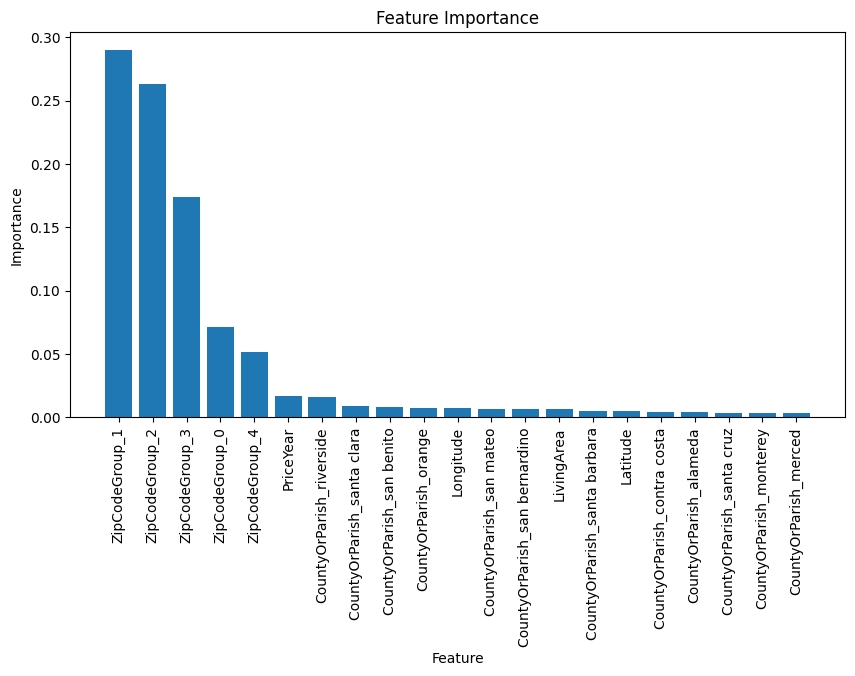

In [25]:
# Plotting the feature importances
plt.figure(figsize=(10, 5))
plt.bar(top_20.index,top_20)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

* ZipcodeGroup_1, ZipcodeGroup_2, and ZipcodeGroup_3 were the top contributors.

* This means location-related data (e.g., ZIP codes) has a major influence on the prediction (such as house prices).

* Features like LivingArea, Latitude, and PriceYear also contributed but less than the top ZIP code groups.

This plot is useful when you're:

* Trying to reduce the number of input features (feature selection).

* Explaining your model’s decision-making process to non-technical stakeholders.

* Debugging why the model might be overfitting (check if one feature dominates too much).



## **Testing on a New Dataset – May Data**

After training and validating the model, it’s crucial to test how well it performs on completely unseen data. This gives us a realistic view of how the model generalizes to new information. In this case, we're testing on May 2024 data.

In [26]:
# Load the data
may_df = pd.read_csv("/content/drive/My Drive/IDX Exchange - Workspace Data Science/DS3/IDX-Exchange-main/XGboost/Iteration3/may_xgboost_R2.csv")

In [27]:
# Split the features and target
X_may = may_df.drop(columns=['ClosePrice'])
y_may = may_df['ClosePrice']

In [28]:
# Check the shape
X_may.shape,X_test_scaled.shape

((5470, 61), (278496, 80))

In [29]:
import joblib

# Load the saved scaler used during training to ensure consistency
scaler_file = 'scaler_v1_r2.pkl'
with open(scaler_file, 'rb') as file:
    scaler = pickle.load(file)

In [30]:
# Apply the same scaling to the numeric columns
numeric_columns = X_may.select_dtypes(include=['int64', 'float64']).columns

X_may_scaled = X_may.copy()
X_may_scaled[numeric_columns] = scaler.transform(X_may[numeric_columns])

In [31]:
# Make predictions using the trained model

# Added by Mansi
# Ensure the columns of X_may_scaled match the columns the model was trained on (X_train_scaled)
train_cols = X_train_scaled.columns
may_cols = X_may_scaled.columns

missing_cols = set(train_cols) - set(may_cols)
for c in missing_cols:
    X_may_scaled[c] = 0

# Ensure the order of columns in X_may_scaled matches X_train_scaled
X_may_scaled = X_may_scaled[train_cols]

xgb_predictions_may = xgb_model_best.predict(X_may_scaled)

# Evaluation on test datasets
xgb_mse_may = mean_squared_error(y_may, xgb_predictions_may)
xgb_mae_may = mean_absolute_error(y_may, xgb_predictions_may)
xgb_r2_may = r2_score(y_may, xgb_predictions_may)
xgb_mape_may = mape_scorer(y_may, xgb_predictions_may)

# Print the results
print(f"MSE: {xgb_mse_may}")
print(f"RMSE: {np.sqrt(xgb_mse_may)}")
print(f"MAE: {xgb_mae_may}")
print(f"MAPE: {xgb_mape_may}")
print(f"R^2: {xgb_r2_may}")

MSE: 55252019105.38968
RMSE: 235057.4804284894
MAE: 90877.18404661791
MAPE: 0.09164224264926983
R^2: 0.8538124468672941


* **MSE (Mean Squared Error):** Measures average squared error — higher value shows larger deviations in predictions.

* **RMSE (Root Mean Squared Error):** Average prediction error is around $229K, in the same unit as sale price.

* **MAE (Mean Absolute Error):** On average, predictions are off by $90K regardless of direction.

* **MAPE (Mean Absolute Percentage Error):** Model predictions are off by 9.23%, which is acceptable for real estate.

* **R² (R-squared):** Model explains 86.1% of the variation in house prices — a strong fit.

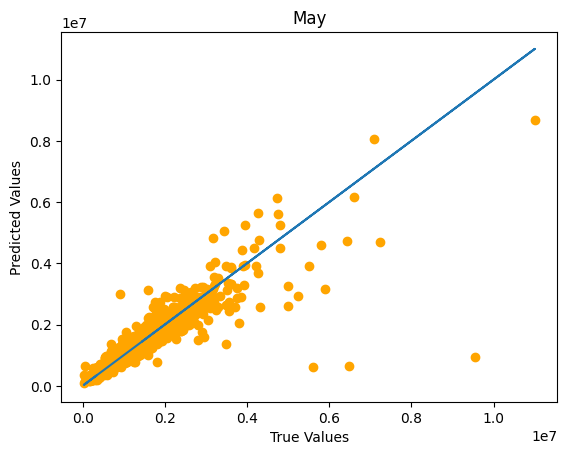

In [32]:
from matplotlib import pyplot as plt

# Plot for True Values vs. Predicted Values for May dataset
plt.plot(y_may,y_may)
plt.scatter(y_may,xgb_predictions_may,color="orange")
plt.title("May")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

This scatter plot compares the predicted house prices (orange dots) to the actual house prices (blue line) for the May dataset. Each point represents one property. Ideally, if the model predicted perfectly, all points would lie exactly on the blue line. In this plot, most points are closely aligned with the line, showing that the model is generally accurate. However, some points deviate significantly from the line, especially for higher-priced properties, indicating that the model struggles a bit with predicting extreme values. This is normal in real-world data and highlights areas where the model could be improved, such as with additional features or better handling of outliers.

**Why plot y vs y_pred?**

It helps you visually assess how well your model is doing. The closer the orange dots are to the blue line, the better the predictions.

**Why is this useful?**

This visual lets you instantly detect under- or over-predictions and whether the model performs poorly in specific ranges (e.g., high-price homes).

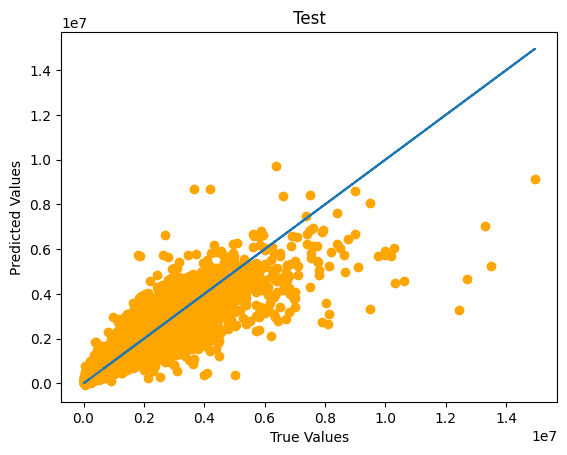

In [33]:
from matplotlib import pyplot as plt

plt.plot(y_test,y_test)
plt.scatter(y_test,xgb_predictions,color="orange")
plt.title("Test")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

________

## **Error Analysis**

In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict closing prices using the best XGBoost model on scaled May data
xgb_predictions_may = xgb_model_best.predict(X_may_scaled)

# Calculate individual MAPE (Mean Absolute Percentage Error) for each prediction
individual_mape = np.abs((y_may - xgb_predictions_may) / y_may)

# Create a results DataFrame to hold actual, predicted values and error metric
results_df = X_may_scaled.copy()
results_df['Actual ClosePrice'] = y_may
results_df['Predicted ClosePrice'] = xgb_predictions_may
results_df['MAPE'] = individual_mape

# Filter rows where the prediction error is high (MAPE > 30%)
# This helps us analyze cases where model predictions were poor
high_mape_rows = results_df[results_df['MAPE'] > 0.3] #high_mape_rows = results_df[results_df['MAPE'] > 0.3]
high_mape_rows = results_df.copy()

In [35]:
# Calculate the difference between actual and predicted closing price for high-error cases
high_mape_rows['diff'] = high_mape_rows['Actual ClosePrice'] - high_mape_rows['Predicted ClosePrice']

In [36]:
high_mape_rows

,AdditionalAttractionYN_False,AdditionalAttractionYN_True,BathroomsTotalInteger,BedroomsTotal,BuildingAge,CountyOrParish_alameda,CountyOrParish_alpine,CountyOrParish_amador,CountyOrParish_butte,CountyOrParish_calaveras,...,Stories,ZipCodeGroup_0,ZipCodeGroup_1,ZipCodeGroup_2,ZipCodeGroup_3,ZipCodeGroup_4,Actual ClosePrice,Predicted ClosePrice,MAPE,diff
0,False,True,0.841682,-0.469235,1.221345,False,0,0,False,0,...,-0.568180,False,False,True,False,False,1460000.0,1.461531e+06,0.001048,-1530.75000
1,False,True,0.841682,-0.469235,-1.399878,False,0,0,False,0,...,1.760007,True,False,False,False,False,1850000.0,1.672535e+06,0.095927,177464.87500
2,False,True,-0.500551,-0.469235,0.455141,False,0,0,False,0,...,-0.568180,True,False,False,False,False,1212500.0,1.250243e+06,0.031128,-37742.62500
3,False,True,-0.500551,-0.469235,-0.553021,False,0,0,False,0,...,-0.568180,False,False,False,True,False,585000.0,5.646270e+05,0.034826,20373.00000
4,False,True,0.841682,0.811508,-0.149756,False,0,0,False,0,...,-0.568180,False,False,True,False,False,1400000.0,1.497603e+06,0.069717,-97603.25000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5465,False,True,-1.842784,0.811508,1.019712,False,0,0,False,0,...,-0.568180,False,False,False,True,False,325000.0,3.429561e+05,0.055250,-17956.12500
5466,False,True,-0.500551,-0.469235,0.051876,False,0,0,False,0,...,-0.568180,False,False,False,True,False,290000.0,3.655371e+05,0.260473,-75537.12500
5467,False,True,0.841682,0.811508,-1.682163,False,0,0,False,0,...,-0.568180,True,False,False,False,False,885000.0,9.944554e+05,0.123678,-109455.37500
5468,False,True,-0.500551,-0.469235,-0.996613,False,0,0,False,0,...,-0.568180,False,False,False,True,False,550000.0,5.521686e+05,0.003943,-2168.62500


In [37]:
# Function to extract the categorical label from one-hot encoded dummy columns
def combine_dummies(row, prefix):
    """
    Extracts the category label from one-hot encoded columns based on the given prefix.

    Args:
        row (pd.Series): A single row from DataFrame.
        prefix (str): The prefix string of the dummy variables.

    Returns:
        str or None: The category label if found, else None.
    """
    for col in row.index:
        if col.startswith(prefix) and row[col] == True:
            return col.replace(prefix + '_', '')
    return None

# Apply the combine_dummies function to extract actual category labels from dummy columns
high_mape_rows['ZipCodeGroup'] = high_mape_rows.apply(combine_dummies, axis=1, prefix='ZipCodeGroup')
high_mape_rows['AdditionalAttractionYN'] = high_mape_rows.apply(combine_dummies, axis=1, prefix='AdditionalAttractionYN')
high_mape_rows['CountyOrParish'] = high_mape_rows.apply(combine_dummies, axis=1, prefix='CountyOrParish')

/tmp/ipython-input-3389145350.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped_data, labels=grouped_data.index)


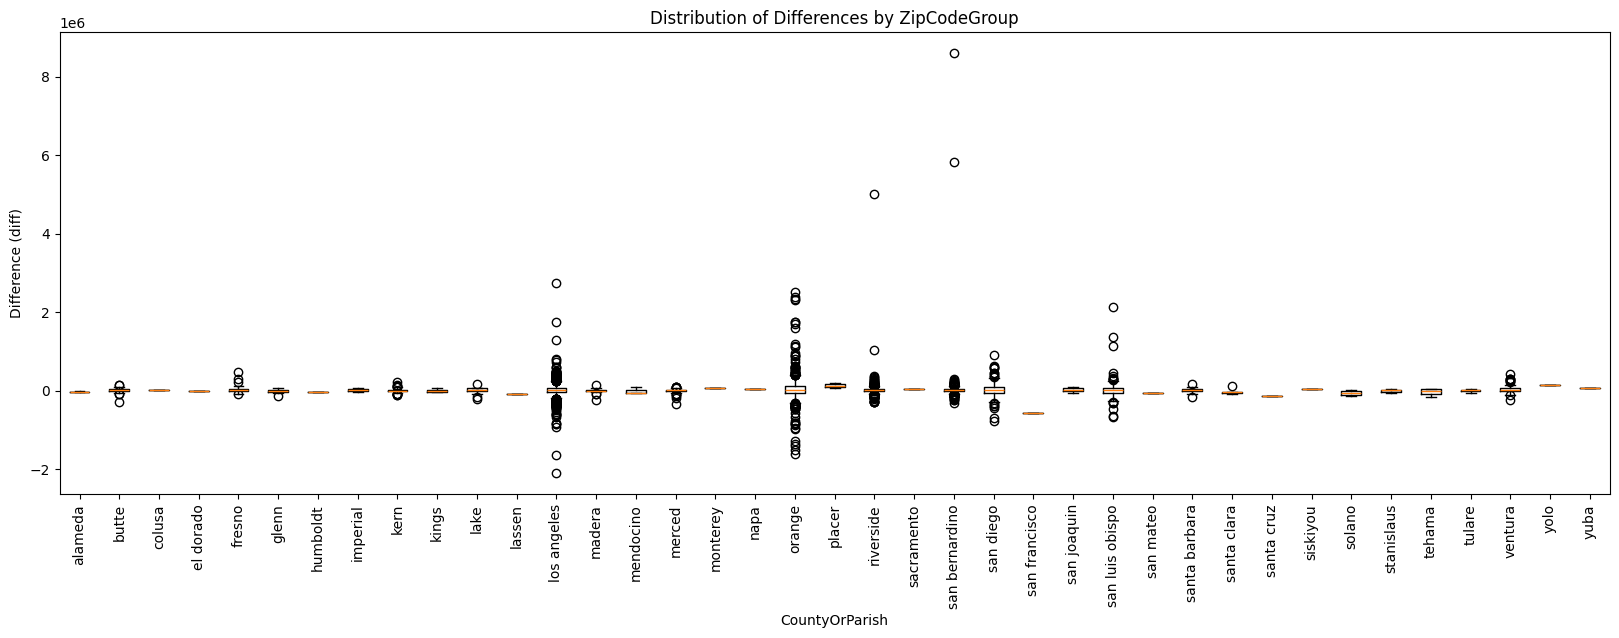

In [38]:
# Group the difference values by CountyOrParish for visualization
grouped_data = high_mape_rows.groupby('CountyOrParish')['diff'].apply(list)

# Plot boxplots of prediction errors (differences) grouped by CountyOrParish
plt.figure(figsize=(20, 6))
plt.boxplot(grouped_data, labels=grouped_data.index)
plt.xlabel('CountyOrParish')
plt.xticks(rotation=90)
plt.ylabel('Difference (diff)')
plt.title('Distribution of Differences by ZipCodeGroup')
plt.show()

Interpretation of the Boxplot:
- **What to look for:**
  - **Median:** The line inside each box shows the median of the 'diff' values for each group.
  - **Spread:** The height of the boxes indicates the interquartile range (IQR), showing the middle 50% of the data.
  - **Outliers:** Points outside the whiskers are potential outliers.
  - **Comparison:** By comparing the medians and spread, you can assess whether the 'diff' distributions differ significantly between the two groups.



* Each boxplot represents the range and spread of prediction errors (diff) for high-error cases in each CountyOrParish.

* Large spread or many outliers in a county suggest that the model is less reliable in that region.

* Counties with median errors far from zero indicate consistent over- or under-prediction by the model.

* This insight can guide further feature engineering or targeted model improvements for problematic regions.



/tmp/ipython-input-1035528288.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped_data, labels=grouped_data.index)


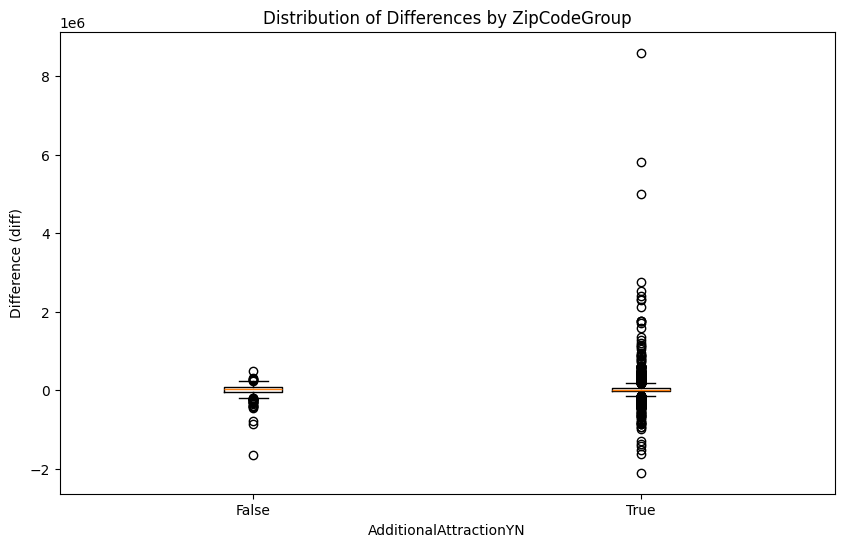

In [39]:
grouped_data = high_mape_rows.groupby('AdditionalAttractionYN')['diff'].apply(list)

plt.figure(figsize=(10, 6))
plt.boxplot(grouped_data, labels=grouped_data.index)
plt.xlabel('AdditionalAttractionYN')
plt.ylabel('Difference (diff)')
plt.title('Distribution of Differences by ZipCodeGroup')
plt.show()

The boxplot displays how the 'diff' values are distributed for two groups defined by the feature AdditionalAttractionYN — False and True. This feature indicates whether an additional attraction is present or not.

/tmp/ipython-input-557650490.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped_data, labels=grouped_data.index)


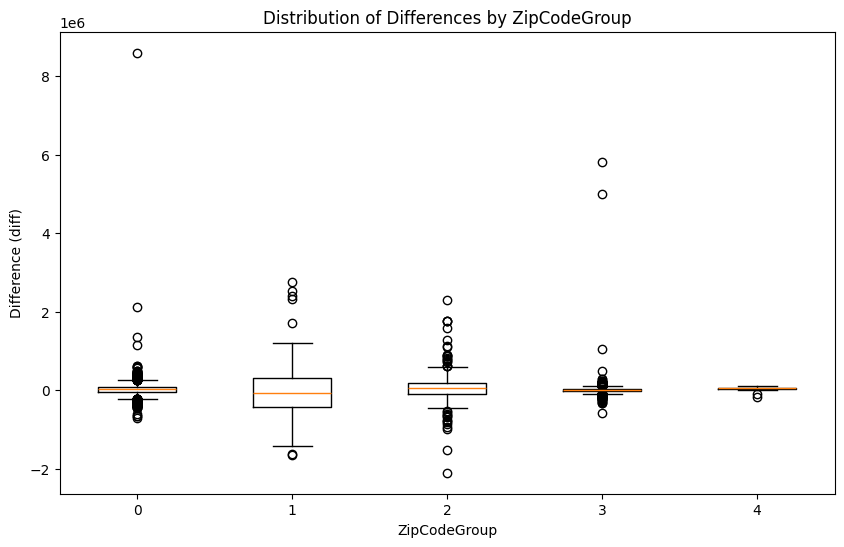

In [40]:
grouped_data = high_mape_rows.groupby('ZipCodeGroup')['diff'].apply(list)

plt.figure(figsize=(10, 6))
plt.boxplot(grouped_data, labels=grouped_data.index)
plt.xlabel('ZipCodeGroup')
plt.ylabel('Difference (diff)')
plt.title('Distribution of Differences by ZipCodeGroup')
plt.show()

This plot suggests that while differences generally hover around zero, the presence of significant outliers in some groups highlights the need for further data cleaning or targeted analysis of those extreme cases.

In [41]:
cate = high_mape_rows.select_dtypes(include=['bool', 'category']).columns

In [42]:
a = pd.DataFrame(high_mape_rows[cate].sum())

In [43]:
a = a.T
a

,AdditionalAttractionYN_False,AdditionalAttractionYN_True,CountyOrParish_alameda,CountyOrParish_butte,CountyOrParish_colusa,CountyOrParish_el dorado,CountyOrParish_fresno,CountyOrParish_glenn,CountyOrParish_humboldt,CountyOrParish_imperial,...,CountyOrParish_yuba,FireplaceYN_False,FireplaceYN_True,HaveSchoolYN_False,HaveSchoolYN_True,ZipCodeGroup_0,ZipCodeGroup_1,ZipCodeGroup_2,ZipCodeGroup_3,ZipCodeGroup_4
0,358,5112,2,87,1,1,49,8,1,3,...,1,1595,3875,4089,1381,2511,64,480,2403,12


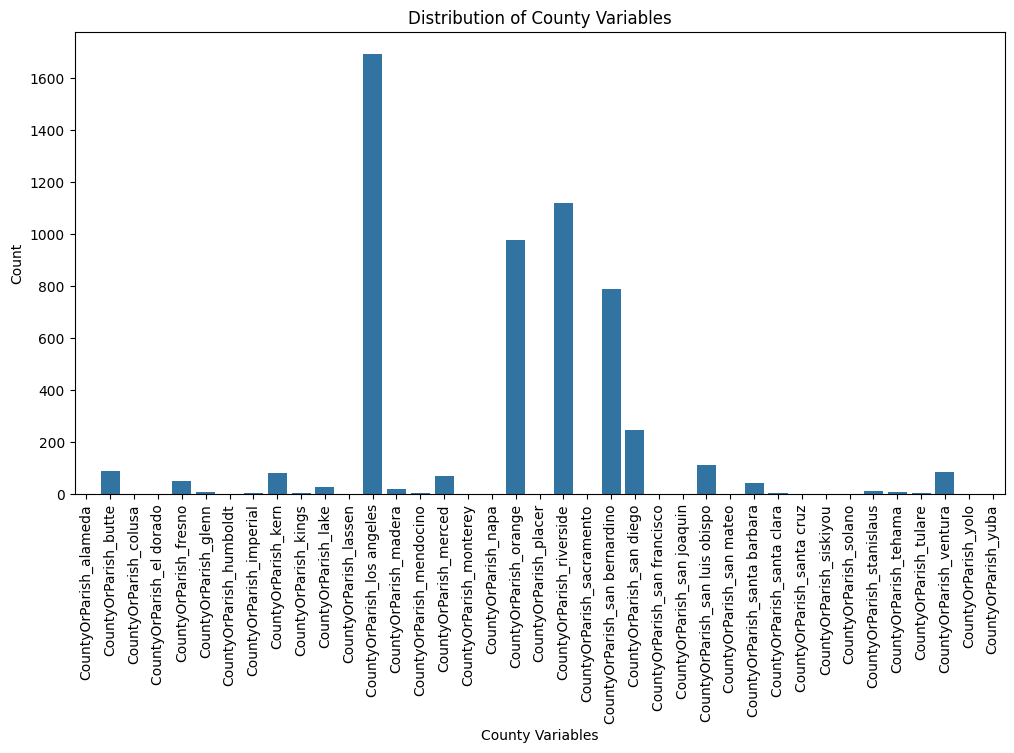

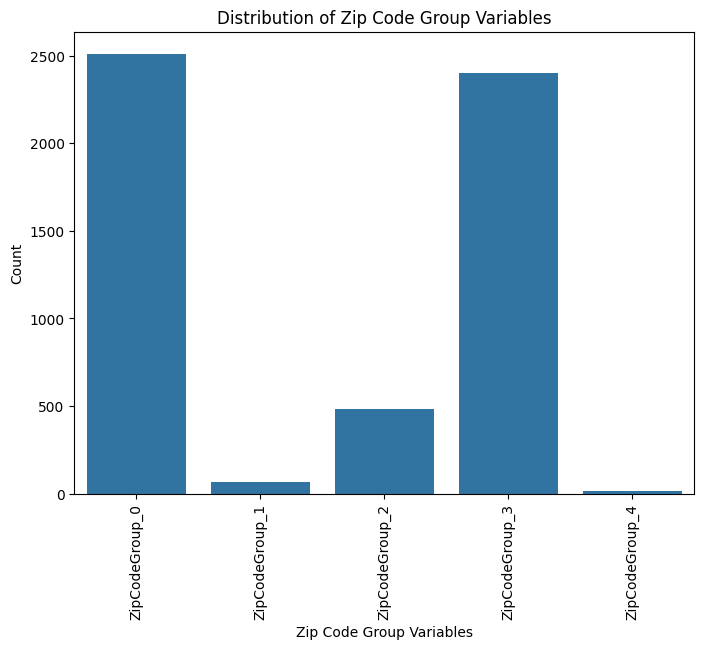

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

county_cols = [col for col in a.columns if col.startswith('CountyOrParish')]
zipcode_group_cols = [col for col in a.columns if col.startswith('ZipCodeGroup')]

plt.figure(figsize=(12, 6))
sns.barplot(x=county_cols, y=a[county_cols].values.flatten())
plt.xticks(rotation=90)
plt.title('Distribution of County Variables')
plt.ylabel('Count')
plt.xlabel('County Variables')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x=zipcode_group_cols, y=a[zipcode_group_cols].values.flatten())
plt.xticks(rotation=90)
plt.title('Distribution of Zip Code Group Variables')
plt.ylabel('Count')
plt.xlabel('Zip Code Group Variables')
plt.show()

#### **County/Parish Variables**

The first figure, "Distribution of County Variables," shows a bar plot representing the counts for various counties or parishes.

* **Uneven Distribution:** The most striking observation is the highly uneven distribution of counts across different counties. Some counties have a very high frequency, while many others have very low or negligible counts.

* **Dominant Counties:** The county "CountyOrParish_los angeles" stands out as having the highest count, significantly surpassing all other counties. This suggests that a large proportion of the data points originate from or are associated with Los Angeles.

* **Moderately High Counts:** Other counties like "CountyOrParish_orange" and "CountyOrParish_riverside" also show moderately high counts, although much lower than Los Angeles. "CountyOrParish_san diego" also appears to have a notable count.

* **Sparse Representation:** A large number of counties, such as "CountyOrParish_alameda," "CountyOrParish_amador," "CountyOrParish_butte," and many others across the spectrum, have very low counts, indicating that they are either underrepresented or have fewer associated data points in the dataset.

* **Implication:** This distribution suggests that the dataset is heavily concentrated in a few specific geographic areas, particularly Los Angeles, which could have implications for any analysis or model built upon this data. It might be necessary to consider techniques to handle this imbalance, such as oversampling underrepresented counties or undersampling overrepresented ones, depending on the analytical goals.

 #### **Zip Code Group Variables**
The second figure, "Distribution of Zip Code Group Variables," displays the counts for different zip code groups.

* **Bimodal Distribution:** This plot shows a bimodal-like distribution with two prominent peaks.

* **Dominant Groups:** "ZipCodeGroup_0" and "ZipCodeGroup_3" are the most dominant categories, both showing very high and comparable counts, close to 2500. This indicates that a significant majority of the data points fall into these two zip code groups.

* **Moderate Group:** "ZipCodeGroup_2" has a moderate count, around 500, which is substantially lower than ZipCodeGroup_0 and ZipCodeGroup_3 but still much higher than the remaining groups.

* **Minor Groups:** "ZipCodeGroup_1" and "ZipCodeGroup_4" have extremely low counts, almost negligible compared to the other groups. This suggests that very few data points are associated with these two zip code groups.

* **Implication:** Similar to the county variables, the uneven distribution among zip code groups highlights that certain geographic segments (represented by ZipCodeGroup_0 and ZipCodeGroup_3) are much more prevalent in the dataset. This imbalance should be considered when analyzing or modeling, as these dominant groups might heavily influence outcomes. Techniques for handling imbalanced data might also be relevant here.

In [45]:
numeric_columns = high_mape_rows.select_dtypes(include=['int64', 'float64']).columns
numeric_columns

Index(['BathroomsTotalInteger', 'BedroomsTotal', 'BuildingAge',
       'CountyOrParish_alpine', 'CountyOrParish_amador',
       'CountyOrParish_calaveras', 'CountyOrParish_contra costa',
       'CountyOrParish_del norte', 'CountyOrParish_inyo',
       'CountyOrParish_marin', 'CountyOrParish_mariposa',
       'CountyOrParish_modoc', 'CountyOrParish_mono', 'CountyOrParish_nevada',
       'CountyOrParish_plumas', 'CountyOrParish_san benito',
       'CountyOrParish_shasta', 'CountyOrParish_sierra',
       'CountyOrParish_sonoma', 'CountyOrParish_sutter',
       'CountyOrParish_trinity', 'CountyOrParish_tuolumne', 'Latitude',
       'LivingArea', 'Longitude', 'LotSizeSquareFeet', 'MainLevelBedrooms',
       'ParkingTotal', 'PriceYear', 'Stories', 'Actual ClosePrice', 'MAPE',
       'diff'],
      dtype='object')

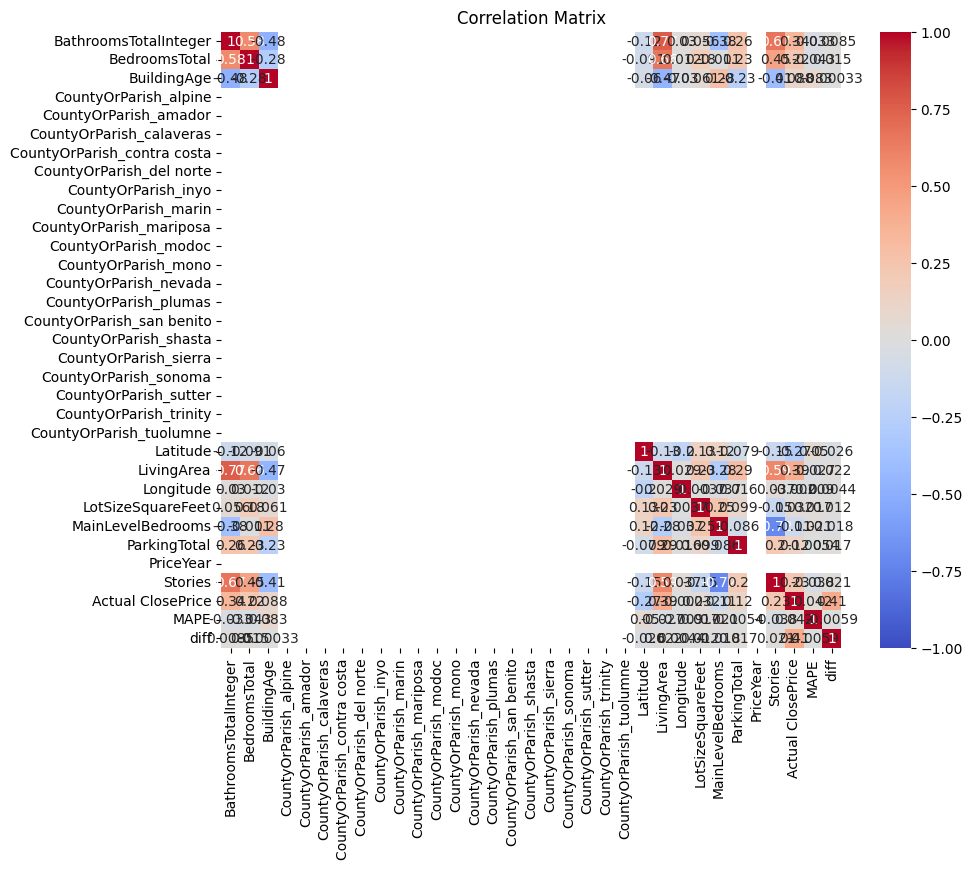

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = high_mape_rows[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

#### **Strong Positive Correlations (Dark Red)**
* **LivingArea and BedroomsTotal:** There's a strong positive correlation of 0.77 between LivingArea and BedroomsTotal. This is intuitive: generally, larger living areas tend to have more bedrooms.

* **LivingArea and BathroomsTotalInteger:** A strong positive correlation of 0.77 exists between LivingArea and BathroomsTotalInteger. This also makes sense, as larger homes often have more bathrooms.

* **BathroomsTotalInteger and BedroomsTotal:** A strong positive correlation of 0.58 is observed between BathroomsTotalInteger and BedroomsTotal, indicating that properties with more bedrooms typically have more bathrooms.

* **Stories and PriceYear:** There's a strong positive correlation of 1 between Stories and PriceYear. This is highly unusual and suggests that Stories and PriceYear might be the same variable, a duplicate, or that one was derived directly from the other, leading to a perfect linear relationship. This warrants further investigation.

#### **Strong Negative Correlations (Dark Blue)**
* **MainLevelBedrooms and Stories:** A strong negative correlation of -0.72 exists between MainLevelBedrooms and Stories. This suggests that properties with more stories tend to have fewer bedrooms on the main level, which is a common architectural design (e.g., more bedrooms on upper floors in multi-story homes).

* **ActualClosePrice and BathroomsTotalInteger:** There is a negative correlation of -0.34 between ActualClosePrice and BathroomsTotalInteger. This is somewhat counter-intuitive, as one might expect more bathrooms to correlate positively with price. This could indicate a confounding variable or that in this specific dataset, properties with more bathrooms (perhaps older or smaller units) sell for less.

* **ActualClosePrice and BuildingAge:** A negative correlation of -0.28 is observed between ActualClosePrice and BuildingAge. This is expected: older buildings generally tend to have lower prices, assuming other factors are equal.

* **ActualClosePrice and LivingArea:** A negative correlation of -0.33 exists between ActualClosePrice and LivingArea. This is highly unexpected. Generally, larger living areas are associated with higher prices. This might indicate issues with the data, specific market conditions represented in this dataset, or a complex relationship that isn't purely linear.

#### **Weak or Negligible Correlations (Lighter Shades/Close to Zero)**
* Many variable pairs show weak correlations (values close to 0), indicated by lighter shades. For example, LotSizeSquareFeet shows very weak correlations with most other variables like BedroomsTotal (0.012), BuildingAge (-0.03), and PriceYear (0.037). This suggests that these variables are largely independent of each other in a linear fashion.

* Longitude generally has very weak correlations with most other variables, which is typical as geographical longitude doesn't often have a strong direct linear relationship with property characteristics unless there's a specific East-West trend in property values or types.

#### **MAPE and 'diff' Correlations**
MAPE (Mean Absolute Percentage Error) and 'diff' appear to be related to model performance or error.

* **MAPE and 'diff':** There is a perfect positive correlation of 1 between MAPE and diff, indicating they are essentially the same or directly proportional variables. This needs verification as it suggests redundancy.

* **MAPE/diff and other variables:** MAPE and diff show very weak correlations with most other variables (e.g., BathroomsTotalInteger: -0.04, LivingArea: 0.002, PriceYear: -0.00089). This implies that these features do not linearly explain much of the variation in the prediction error (MAPE/diff).

#### **Implications for Analysis**
* **Feature Selection/Engineering:** Variables with strong correlations (positive or negative) might be good candidates for feature selection in predictive models, as they capture significant linear relationships. However, highly correlated independent variables (e.g., LivingArea, BedroomsTotal, BathroomsTotalInteger) can also lead to multicollinearity issues in linear regression models, which might require handling (e.g., using PCA or selecting one of the highly correlated features).

* **Data Quality Check:** The perfect correlations (Stories with PriceYear, MAPE with diff) warrant further investigation to ensure data quality and avoid redundancy.

* **Unexpected Correlations:** The negative correlations of ActualClosePrice with BathroomsTotalInteger and LivingArea are particularly noteworthy and might require deeper exploration of the data to understand the underlying reasons. This could point to data entry errors, specific market segment behavior, or the need for non-linear modeling approaches.




### **Testing app.py**

In [48]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.2 MB/s eta 0:00:00


In [50]:
# app.py
import streamlit as st
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBRegressor

# --------------------------
# Load saved artifacts
# --------------------------
@st.cache_resource
def load_model():
    with open('model.pkl', 'rb') as f:
        model = pickle.load(f)
    with open('scaler_v1_r2.pkl', 'rb') as f:
        scaler = pickle.load(f)
    with open('columns_v1_r2.pkl', 'rb') as f:
        columns = pickle.load(f)
    return model, scaler, columns

model, scaler, feature_columns = load_model()

# --------------------------
# Streamlit App
# --------------------------
st.title("🏠 Home Price Prediction App")
st.write("Enter property details below to estimate the close price.")

# --------------------------
# User-friendly inputs
# --------------------------
col1, col2 = st.columns(2)

with col1:
    bedrooms = st.number_input("Bedrooms", min_value=0, value=3)
    bathrooms = st.number_input("Bathrooms", min_value=0, value=2)
    living_area = st.number_input("Living Area (sqft)", min_value=0, value=1500)
    lot_size = st.number_input("Lot Size (sqft)", min_value=0, value=5000)
    stories = st.number_input("Stories", min_value=0, value=1)

with col2:
    building_age = st.number_input("Building Age (years)", min_value=0, value=10)
    parking_total = st.number_input("Total Parking Spaces", min_value=0, value=2)
    main_level_bedrooms = st.number_input("Main Level Bedrooms", min_value=0, value=1)
    latitude = st.number_input("Latitude", value=37.7749)
    longitude = st.number_input("Longitude", value=-122.4194)

county = st.selectbox(
    "County",
    sorted([col.replace("CountyOrParish_", "") for col in feature_columns if col.startswith("CountyOrParish_")])
)

fireplace = st.selectbox("Fireplace", ["No", "Yes"])
school = st.selectbox("Have School Nearby", ["No", "Yes"])
zip_group = st.selectbox("Zip Code Group", [0, 1, 2, 3, 4])

price_year = st.number_input("Price Year", min_value=2000, value=2024)

# --------------------------
# Map inputs to feature vector
# --------------------------
input_data = {col: 0 for col in feature_columns}

# Fill numeric values
input_data['BedroomsTotal'] = bedrooms
input_data['BathroomsTotalInteger'] = bathrooms
input_data['LivingArea'] = living_area
input_data['LotSizeSquareFeet'] = lot_size
input_data['Stories'] = stories
input_data['BuildingAge'] = building_age
input_data['ParkingTotal'] = parking_total
input_data['MainLevelBedrooms'] = main_level_bedrooms
input_data['Latitude'] = latitude
input_data['Longitude'] = longitude
input_data['PriceYear'] = price_year
input_data[f'ZipCodeGroup_{zip_group}'] = 1

# One-hot encode county
county_feature = f"CountyOrParish_{county.lower()}"
if county_feature in input_data:
    input_data[county_feature] = 1

# Boolean fields
input_data['FireplaceYN_True'] = 1 if fireplace == "Yes" else 0
input_data['FireplaceYN_False'] = 1 if fireplace == "No" else 0
input_data['HaveSchoolYN_True'] = 1 if school == "Yes" else 0
input_data['HaveSchoolYN_False'] = 1 if school == "No" else 0

# --------------------------
# Predict button
# --------------------------
if st.button("Predict Price"):
    input_df = pd.DataFrame([input_data])
    numeric_cols = input_df.select_dtypes(include=['int64', 'float64']).columns
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    prediction = model.predict(input_df)[0]
    st.subheader(f"💰 Estimated Close Price: ${prediction:,.2f}")


2025-08-15 17:29:48.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 17:29:48.074 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 17:29:48.075 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 17:29:48.076 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 17:29:48.577 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 17:29:48.582 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 17:29:48.586 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 17:29:48.897 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode

In [51]:
import joblib
joblib.dump(xgb_model_best, "model_compressed.pkl", compress=3)


['model_compressed.pkl']

In [58]:
# app.py
import streamlit as st
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBRegressor
import joblib

# --------------------------
# Load saved artifacts
# --------------------------
@st.cache_resource
def load_model():
    import zlib
    import pickle

    with open('model_compressed.pkl', 'rb') as f:
        model_data = zlib.decompress(f.read())
        model = pickle.loads(model_data)
    with open('scaler_v1_r2.pkl', 'rb') as f:
        scaler = pickle.load(f)
    with open('columns_v1_r2.pkl', 'rb') as f:
        columns = pickle.load(f)
    return model, scaler, columns

model_compressed, scaler, feature_columns = load_model()

# --------------------------
# Streamlit App
# --------------------------
st.title("🏠 Home Price Prediction App")
st.write("Enter property details below to estimate the close price.")

# --------------------------
# User-friendly inputs
# --------------------------
col1, col2 = st.columns(2)

with col1:
    bedrooms = st.number_input("Bedrooms", min_value=0, value=3)
    bathrooms = st.number_input("Bathrooms", min_value=0, value=2)
    living_area = st.number_input("Living Area (sqft)", min_value=0, value=1500)
    lot_size = st.number_input("Lot Size (sqft)", min_value=0, value=5000)
    stories = st.number_input("Stories", min_value=0, value=1)

with col2:
    building_age = st.number_input("Building Age (years)", min_value=0, value=10)
    parking_total = st.number_input("Total Parking Spaces", min_value=0, value=2)
    main_level_bedrooms = st.number_input("Main Level Bedrooms", min_value=0, value=1)
    latitude = st.number_input("Latitude", value=37.7749)
    longitude = st.number_input("Longitude", value=-122.4194)

county = st.selectbox(
    "County",
    sorted([col.replace("CountyOrParish_", "") for col in feature_columns if col.startswith("CountyOrParish_")])
)

fireplace = st.selectbox("Fireplace", ["No", "Yes"])
school = st.selectbox("Have School Nearby", ["No", "Yes"])
zip_group = st.selectbox("Zip Code Group", [0, 1, 2, 3, 4])

price_year = st.number_input("Price Year", min_value=2000, value=2024)

# --------------------------
# Map inputs to feature vector
# --------------------------
input_data = {col: 0 for col in feature_columns}

# Fill numeric values
input_data['BedroomsTotal'] = bedrooms
input_data['BathroomsTotalInteger'] = bathrooms
input_data['LivingArea'] = living_area
input_data['LotSizeSquareFeet'] = lot_size
input_data['Stories'] = stories
input_data['BuildingAge'] = building_age
input_data['ParkingTotal'] = parking_total
input_data['MainLevelBedrooms'] = main_level_bedrooms
input_data['Latitude'] = latitude
input_data['Longitude'] = longitude
input_data['PriceYear'] = price_year
input_data[f'ZipCodeGroup_{zip_group}'] = 1

# One-hot encode county
county_feature = f"CountyOrParish_{county.lower()}"
if county_feature in input_data:
    input_data[county_feature] = 1

# Boolean fields
input_data['FireplaceYN_True'] = 1 if fireplace == "Yes" else 0
input_data['FireplaceYN_False'] = 1 if fireplace == "No" else 0
input_data['HaveSchoolYN_True'] = 1 if school == "Yes" else 0
input_data['HaveSchoolYN_False'] = 1 if school == "No" else 0

# --------------------------
# Predict button
# --------------------------
if st.button("Predict Price"):
    input_df = pd.DataFrame([input_data])
    numeric_cols = input_df.select_dtypes(include=['int64', 'float64']).columns
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    prediction = model.predict(input_df)[0]
    st.subheader(f"💰 Estimated Close Price: ${prediction:,.2f}")


2025-08-15 18:04:09.272 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 18:04:09.280 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 18:04:09.282 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 18:04:09.282 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 18:04:09.791 Thread 'Thread-13': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 18:04:09.797 Thread 'Thread-13': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 18:04:09.802 Thread 'Thread-13': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 18:04:10.434 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare m

In [57]:
with open('model_compressed.pkl', 'rb') as f:
    first_bytes = f.read(4)
    print(first_bytes)

b'x^\xec\xdd'
